In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_importance

### Analyse and clean input data

In [118]:
# Read CSV and validate
df = pd.read_csv("data/bigml_59c28831336c6604c800002a.csv")

# Analyse dataframe
#print("Shape", df.shape)
#print(df.columns.tolist())
#print(df.head())
#print(df.describe())

# Check for duplicated rows
duplicatedRows = df.duplicated().sum()
print("Number of duplicated rows:", duplicatedRows)

# Check fo
nullValues = df.isnull().sum()
totalNulls = nullValues.sum()
print("Number of null values:", totalNulls)


Number of duplicated rows: 0
Number of null values: 0


### Feature Manipulation

In [ ]:
# Remove 'phone number' as it is a meangingless feature that does not improve predictive power
df.drop(columns=['phone number'], inplace=True)

# Total call amount in minutes - Can measure overall level of usage
df["totalMinutes"] = df["total day minutes"] + df["total eve minutes"] + df["total night minutes"] + df["total intl minutes"]

# Added Total number of calls - Can measure overall level of usage
df["totalCalls"] = df["total day calls"] + df["total eve calls"] + df["total night calls"] + df["total intl calls"]

# Average duration of calls - Users that call for longer periods of time may exhibit different behaviours
df["averageCallDuration"] = df["totalMinutes"] / df["totalCalls"]

# Average charge per minute - Disatissfaction due to suboptimal plans. i.e more international calls 
df["AvgCostPerMin"] = (df["total day charge"] + df["total eve charge"] + df["total night charge"] + df["total intl charge"]) / df["totalMinutes"]

# Convert yes/no and TRUE/FALSE to 1/0
# More importantly, this coverts "international plan", "voice mail plan" and Churn fields to binary for categorical encoding

# Create binary map
binary_map = {'yes': 1, 'no': 0, 'TRUE': 1, 'FALSE': 0}

# Replace values in the dataframe that match the binary map
df.replace(binary_map, inplace=True)

# Label encode 'state' 
le = LabelEncoder()
df['state'] = le.fit_transform(df['state'])

### Feature Selection and Train Model

In [120]:
# Select Churn as the feature
targetFeature = 'churn'
X = df.drop(columns=[targetFeature])
y = df[targetFeature].astype(int)

# Split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

# Train XGBoost model
model = XGBClassifier(
    n_estimators = 300,
    learning_rate = 0.1,
    max_depth = 5,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42,
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)  # handle class imbalance
)


model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Evaluation Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))
print("Classification Report:", classification_report(y_test, y_pred))

Evaluation Results:
Accuracy: 0.9535
ROC-AUC: 0.9046
Classification Report:               precision    recall  f1-score   support

           0       0.97      0.98      0.97       570
           1       0.88      0.79      0.83        97

    accuracy                           0.95       667
   macro avg       0.92      0.89      0.90       667
weighted avg       0.95      0.95      0.95       667



### Confusion Matrix and Feature Importance

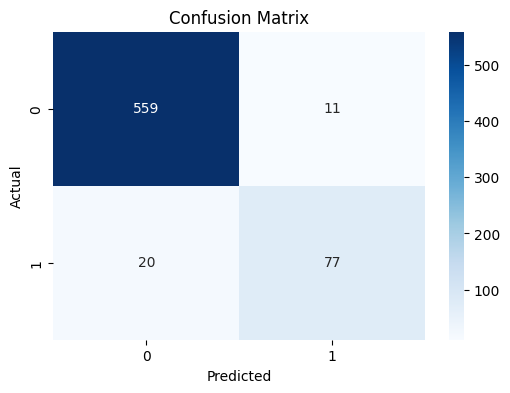

<Figure size 1000x600 with 0 Axes>

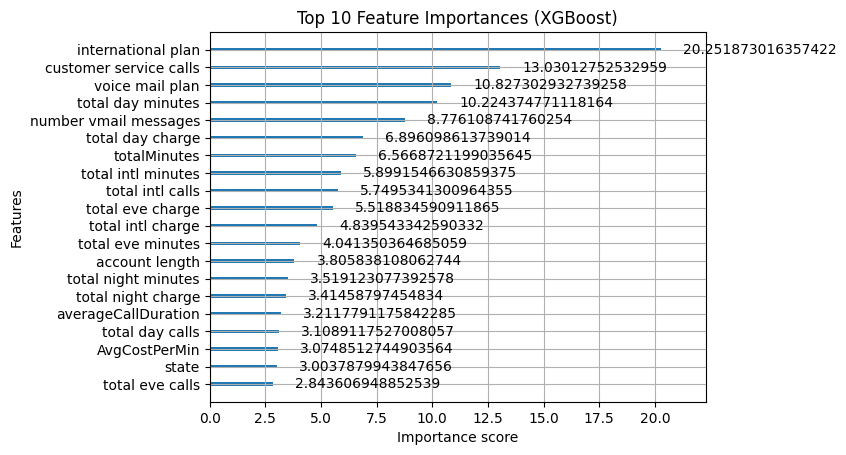

In [121]:

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance
plt.figure(figsize=(10,6))
plot_importance(model, importance_type='gain', max_num_features=20)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

